Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [ ]:
NAME = "Maciej Wilhelmi"

---

# Ewaluacja modeli
W poprzednim zeszycie zbadaliśmy zachowanie różnych metod redukcji wymiarowości jako narzędzia do wizualizacji przestrzeni ukrytych (reprezentacji).

Kolejnym krokiem będzie ewaluacja reprezentacji w konkretnych zadaniach, tak aby uzyskać liczbowe miary oceny jakości.

# 3. Autokoder
Jednym z najprosztych modeli uczenia reprezentacji jest poznany na wykładzie autokoder. Model taki składa się z dwóch modułów: **kodera** oraz **dekodera**. Zbudujemy model oparty na wielowarstwowych perceptronach i zastosujemy go w problemie uczenia reprezentacji dla rozpoznawania odręcznie pisanych cyfr (zbiór `digits` z pakietu scikit-learn). 

In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import torch


X, y = load_digits(return_X_y=True)
X = X / 16.  # Każda cecha ma zakres wartości 0-16

X = torch.tensor(X).float()
y = torch.tensor(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [2]:
print(f"Zbiór digits zawiera: {X.shape[0]:,} instancji")
print(f"Każda cyfra jest opisana przez {X.shape[1]:,} cechy (pixele)")

Zbiór digits zawiera: 1,797 instancji
Każda cyfra jest opisana przez 64 cechy (pixele)


In [4]:
X[1]

tensor([0.0000, 0.0000, 0.0000, 0.7500, 0.8125, 0.3125, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.6875, 1.0000, 0.5625, 0.0000, 0.0000, 0.0000, 0.0000,
        0.1875, 0.9375, 1.0000, 0.3750, 0.0000, 0.0000, 0.0000, 0.4375, 0.9375,
        1.0000, 1.0000, 0.1250, 0.0000, 0.0000, 0.0000, 0.0000, 0.0625, 1.0000,
        1.0000, 0.1875, 0.0000, 0.0000, 0.0000, 0.0000, 0.0625, 1.0000, 1.0000,
        0.3750, 0.0000, 0.0000, 0.0000, 0.0000, 0.0625, 1.0000, 1.0000, 0.3750,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6875, 1.0000, 0.6250, 0.0000,
        0.0000])

## Zadanie 3.1 (0.25 pkt)
Dokończ implementację autokodera. Zarówno koder jak i dekoder zaimplementuj jako dwu-warstwowe perceptrony z aktywacjami ReLU, tzn. (warstwa liniowa, aktywacja, warstwa liniowa, aktywacja). Pomiń ostatnią aktywację w module dekodera.

In [46]:
from torch import nn
from collections import OrderedDict


class Autoencoder(nn.Module):
    
    def __init__(self, feature_dim: int, hidden_dim: int):
        super().__init__()
        
        self.encoder = nn.Sequential(OrderedDict([
            ('en_lin1', nn.Linear(feature_dim, hidden_dim)),
            ('en_relu1', nn.ReLU()),
            ('en_lin2', nn.Linear(hidden_dim, hidden_dim)),
            ('en_relu2', nn.ReLU()),
        ]))
        self.decoder = nn.Sequential(OrderedDict([
            ('de_lin1', nn.Linear(hidden_dim, feature_dim)),
            ('de_relu1', nn.ReLU()),
            ('de_lin2', nn.Linear(feature_dim, feature_dim)),
        ]))
        
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [47]:
import torch
from torch.nn import functional as F
    
    
def train(
    model: Autoencoder, 
    optimizer: torch.optim.Optimizer,
    x: torch.Tensor,
) -> float:
    model.train()
    
    optimizer.zero_grad()
    
    x_rec = model(x)
    loss = F.mse_loss(input=x_rec, target=x)
    
    loss.backward()
    optimizer.step()
    
    return loss.item()


def test(model: Autoencoder, x: torch.Tensor) -> float:
    model.eval()
    
    with torch.no_grad():
        x_rec = model(x)
        loss = F.mse_loss(input=x_rec, target=x)
        
        return loss.item()


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

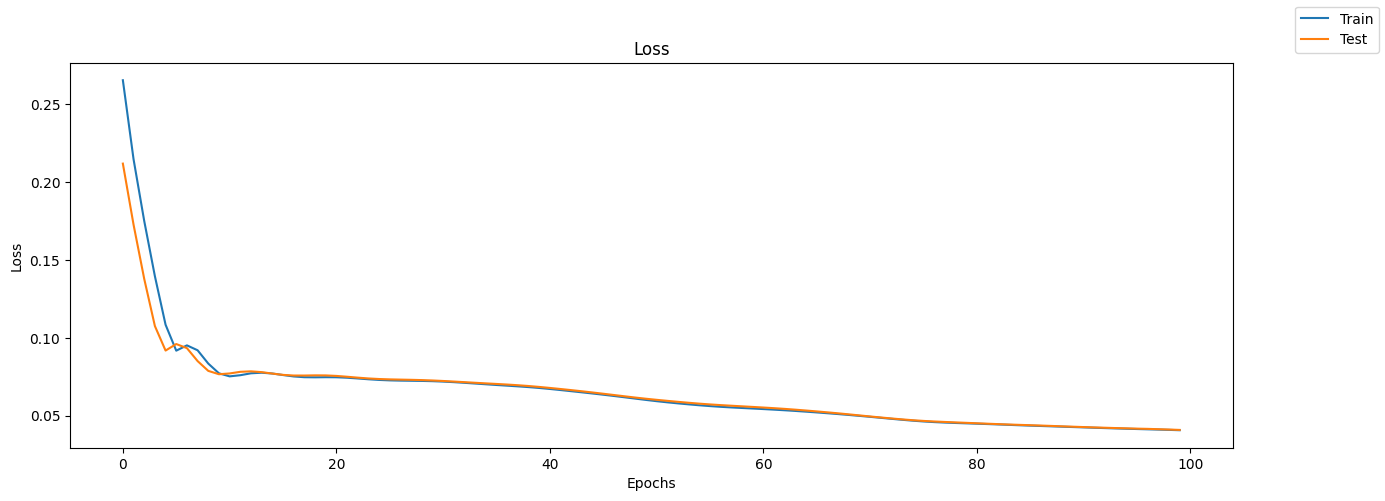

In [56]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm    

NUM_EPOCHS = 100
REPRESENTATION_DIM = 8


ae = Autoencoder(feature_dim=X.shape[1], hidden_dim=REPRESENTATION_DIM)
opt = torch.optim.Adam(ae.parameters(), lr=1e-2)


train_losses = []
test_losses = []

for epoch in tqdm(range(NUM_EPOCHS), desc="Epochs"):
    train_loss = train(model=ae, optimizer=opt, x=X_train)
    test_loss = test(model=ae, x=X_test)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    
    
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_losses, label="Train")
ax.plot(test_losses, label="Test")
ax.set(title="Loss", xlabel="Epochs", ylabel="Loss")
fig.legend()

## Zadanie 3.2 (0.25 pkt)
Zaimplemetuj metodę pozwalającą na ekstrakcję wektorów reprezentacji z modelu autokodera.

In [8]:
ae

Autoencoder(
  (encoder): Sequential(
    (en_lin1): Linear(in_features=64, out_features=8, bias=True)
    (en_relu1): ReLU()
    (en_lin2): Linear(in_features=8, out_features=8, bias=True)
    (en_relu2): ReLU()
  )
  (decoder): Sequential(
    (de_lin1): Linear(in_features=8, out_features=64, bias=True)
    (de_relu1): ReLU()
    (de_lin2): Linear(in_features=64, out_features=64, bias=True)
  )
)

In [58]:
def get_representations(model: Autoencoder, x: torch.Tensor) -> torch.Tensor:
    # TU WPISZ KOD
    model.eval()
    
    with torch.no_grad():
      repr = model(x)
    # print(repr)
    return repr


In [59]:
z_train = get_representations(model=ae, x=X_train)
z_test = get_representations(model=ae, x=X_test)

Wizualizujemy reprezentacje cyfr:

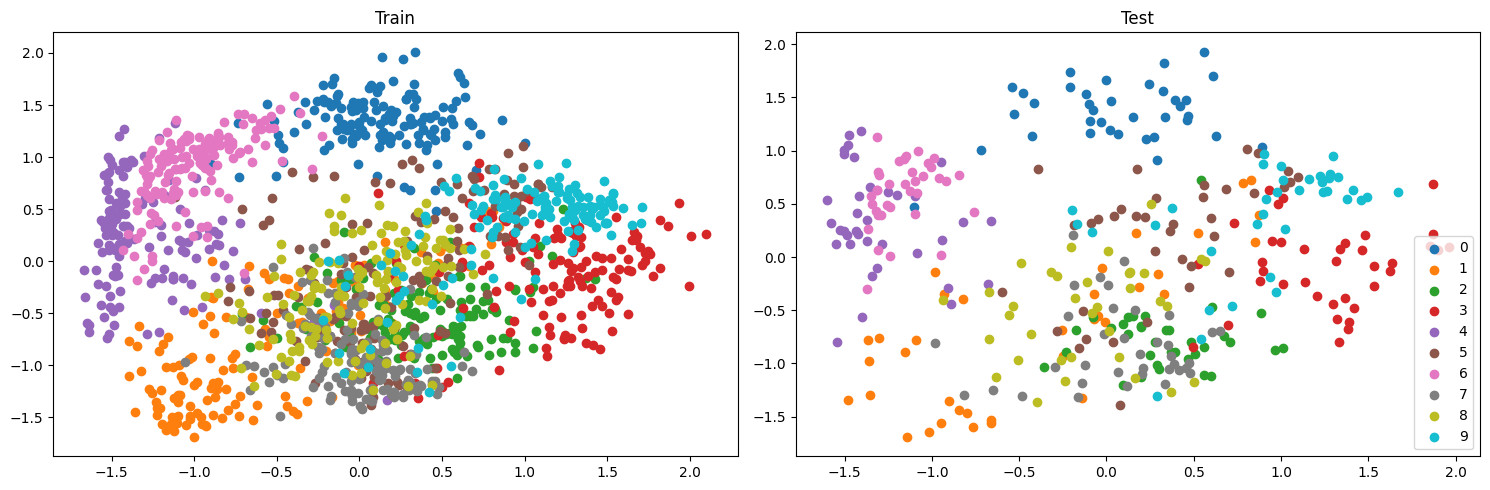

In [60]:
from sklearn.decomposition import PCA

z2d_train = PCA(n_components=2).fit_transform(z_train)
z2d_test = PCA(n_components=2).fit_transform(z_test)


fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

for label in y_train.unique():
    axs[0].scatter(z2d_train[y_train == label, 0], z2d_train[y_train == label, 1], label=label.item())
    axs[1].scatter(z2d_test[y_test == label, 0], z2d_test[y_test == label, 1], label=label.item())

axs[0].set(title="Train")
axs[1].set(title="Test")
axs[1].legend()


fig.tight_layout()

# 4. Ewaluacja liniowa
W przypadku ewaluacji liniowej zamrażamy wagi kodera i uczymy model liniowy na podanym zadaniu.

W naszym przypadku reprezentacje już wyekstrahowaliśmy za pomocą metody `get_representations()`, zatem pozostaje nam etap wyuczenia modelu liniowego. Zastosujemy regresję logistyczną.

## Zadanie 4.1 (1.25 pkt)
Zaimplementuj poniższą funkcję, która wyuczy model regresji logistycznej na danych `(z_train, y_train)`, a następnie obliczy wartość miary AUC na zbiorze treningowym oraz testowym.

In [ ]:
ae.encoder

Sequential(
  (lin1): Linear(in_features=64, out_features=8, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=8, out_features=8, bias=True)
  (relu2): ReLU()
)

In [61]:
from typing import Tuple
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import numpy as np

def evaluate_linear(
    z_train: torch.Tensor,
    y_train: torch.Tensor,
    z_test: torch.Tensor,
    y_test: torch.Tensor,
) -> Tuple[float, float]:
    # TU WPISZ KOD
    lr = LogisticRegression(max_iter=400)
    lr.fit(z_train, y_train)
    # print(type(z_train))

    test_preds = lr.predict_proba(z_test)
    train_preds = lr.predict_proba(z_train)
    # print(test_preds, len(y_test))

    auc_test = roc_auc_score(y_test, test_preds, multi_class='ovr')
    auc_train = roc_auc_score(y_train, train_preds, multi_class='ovr')
        
    return auc_train, auc_test
    
    
    
auc_train, auc_test = evaluate_linear(
    z_train=z_train,
    y_train=y_train,
    z_test=z_test,
    y_test=y_test,
)

print(f"Miara AUC na zbiorze treningowym: {auc_train * 100.:.2f} [%]")
print(f"Miara AUC na zbiorze testowym: {auc_test * 100.:.2f} [%]")

Miara AUC na zbiorze treningowym: 96.43 [%]
Miara AUC na zbiorze testowym: 96.31 [%]


# 5. Ewaluacja douczania / z transferem wiedzy
W tym scenariuszu koder jest uczony łącznie z modelem zadaniowym. Wykorzystamy wyuczony koder i połączymy go z pojedynczą warstwą liniową.

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Miara AUC na zbiorze treningowym: 98.72 [%]
Miara AUC na zbiorze testowym: 98.38 [%]


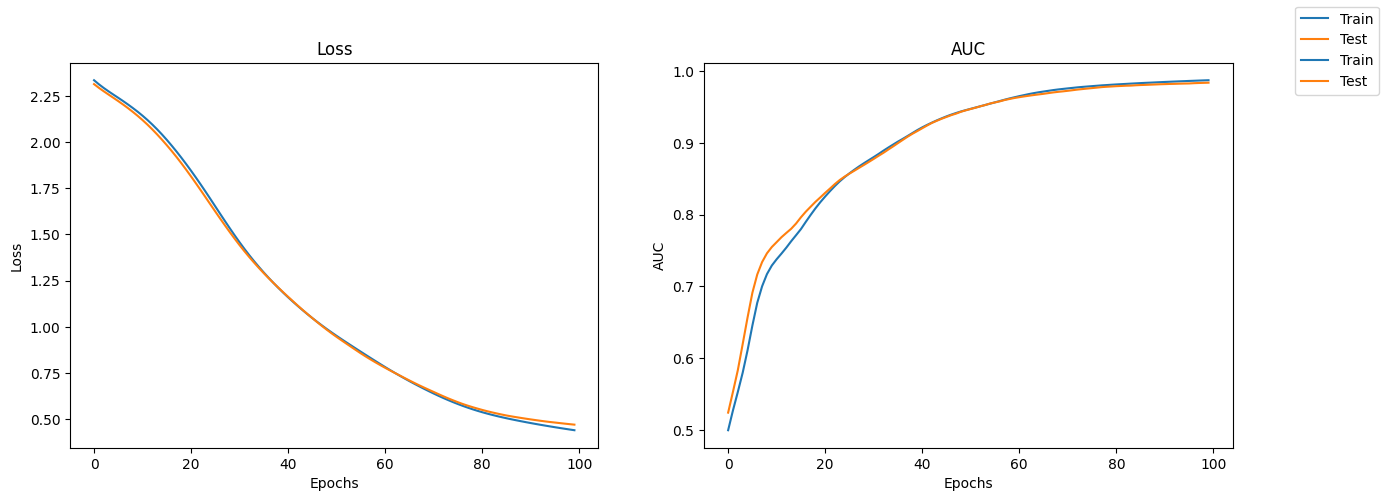

In [62]:
from copy import deepcopy
from sklearn.metrics import roc_auc_score



NUM_CLASSES = 10
NUM_EPOCHS_FINETUNE = 100


class FinetuneModel(nn.Module):
    
    def __init__(self, encoder: nn.Module, representation_dim: int, num_classes: int):
        super().__init__()
        self._encoder = encoder
        self._linear = nn.Linear(representation_dim, num_classes)
        
    def forward(self, x):
        return self._linear(self._encoder(x))
        
        
finetune_model = FinetuneModel(
    encoder=deepcopy(ae.encoder),
    representation_dim=REPRESENTATION_DIM,
    num_classes=NUM_CLASSES,
)
opt = torch.optim.Adam(finetune_model.parameters(), lr=1e-2)


def train_finetune(
    model: FinetuneModel,
    optimizer: torch.optim.Optimizer,
    x: torch.Tensor,
    y: torch.Tensor,
) -> float:
    model.train()
    
    optimizer.zero_grad()
    
    y_pred = model(x)
    loss = F.cross_entropy(input=y_pred, target=y)
    
    loss.backward()
    optimizer.step()
    
    auc = roc_auc_score(
        y_true=y,
        y_score=y_pred.detach().softmax(dim=-1).numpy(),
        multi_class="ovr",
    )
    
    return loss.item(), auc


def test_finetune(
    model: FinetuneModel,
    x: torch.Tensor,
    y: torch.Tensor,
) -> float:
    model.eval()
    
    with torch.no_grad():
        y_pred = model(x)
        loss = F.cross_entropy(input=y_pred, target=y)
        
    auc = roc_auc_score(
        y_true=y,
        y_score=y_pred.softmax(dim=-1).numpy(),
        multi_class="ovr",
    )
    
    return loss.item(), auc


train_losses, train_aucs = [], []
test_losses, test_aucs = [], []

for epoch in tqdm(range(NUM_EPOCHS_FINETUNE), desc="Epochs"):
    train_loss, train_auc = train_finetune(
        model=finetune_model, 
        optimizer=opt,
        x=X_train,
        y=y_train,
    )
    train_losses.append(train_loss)
    train_aucs.append(train_auc)
    
    
    test_loss, test_auc = test_finetune(
        model=finetune_model, 
        x=X_test, 
        y=y_test,
    )
    test_losses.append(test_loss)
    test_aucs.append(test_auc)
    
    
    
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

axs[0].plot(train_losses, label="Train")
axs[0].plot(test_losses, label="Test")
axs[0].set(title="Loss", xlabel="Epochs", ylabel="Loss")

axs[1].plot(train_aucs, label="Train")
axs[1].plot(test_aucs, label="Test")
axs[1].set(title="AUC", xlabel="Epochs", ylabel="AUC")

fig.legend()


print(f"Miara AUC na zbiorze treningowym: {train_aucs[-1] * 100.:.2f} [%]")
print(f"Miara AUC na zbiorze testowym: {test_aucs[-1] * 100.:.2f} [%]")

## Zadanie 5.1 (0.25 pkt)
Który ze scenariuszy ewaluacji pozwala uzyskać lepsze wyniki? Który byś wybrała/wybrał? Uzasadnij.

Lepsze wyniki osiągnął scenariusz z ewaluacją douczania:
- Miara AUC na zbiorze treningowym: 98.72%
- Miara AUC na zbiorze testowym: 98.38%,

niż ewaluacją liniowa:
- Miara AUC na zbiorze treningowym: 96.43%
- Miara AUC na zbiorze testowym: 96.31%

Jeżeli chodzi o prostotę, to ewaluacja liniowa jest o wiele prostszym podejściem i szybszym, ale chcąc uzyskać jak najlepsze wyniki powinniśmy korzystać z douczania modelu. Zatem wybrałbym scenariusz z transferem wiedzy.